# Client Churn Prediction
---

The Top Bank company operates in Europe with a bank account as the main product, this product can keep client's salary and make payments. This account doesn't have any cost in the first 12 months, however, after that time trial, the client needs to rehire the bank for upcoming 12 months and redo this process every year. Recently the Analytics Team noticed that the churn rate is increasing.

As a Data Science Consultant, you need to create an action plan to decrease the number of churn customers and show the financial return on your solution.
At the end of your consultancy, you need to deliver to the TopBottom CEO a model in production, which will receive a customer base via API and return that same base with an extra column with the probability of each customer going into churn.
In addition, you will need to provide a report reporting your model's performance and the financial impact of your solution. Questions that the CEO and the Analytics team would like to see in their report:

1.  What is Top Bank's current Churn rate? How does it vary monthly?
2. What is the performance of the model in classifying customers as churns?
3. What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

> Disclaimer: This is a fictional bussiness case

## PLANNING

### Input

- Predict wheter customer will be in churn;
- Dataset with sales records and customers info.

### Output

- Which customer will be in churn;
- Churn rate of the company;
- Performance of the model;
- Action plan

### Tasks

1. Which customer will be in churn:
    - What is the criterion?
        - Downtime
        - Time remaining until the contract ends


2. Current churn rate of the company:
    - Calculate churn rate
    - Calculate monthly churn rate and variation

3. Performance of the model:
    - TopK score
    - Precision at K score
    - Recall at K score

4. Action plan:
    - Discount
    - Voucher
    - Deposit bonus

## IMPORTS

In [53]:
import pickle
import warnings
import inflection



import numpy                    as np
import pandas                   as pd
import seaborn                  as sns
import scikitplot               as skplt
import sweetviz                 as sv

from pandas_profiling                       import ProfileReport
from IPython.core.display                   import HTML
from IPython.core.display                   import Image
from boruta                                 import BorutaPy
from sklearn.model_selection                import train_test_split
from imblearn.combine                       import SMOTETomek 
from xgboost                                import XGBClassifier, DMatrix
from sklearn.ensemble                       import RandomForestClassifier
from sklearn.linear_model                   import LogisticRegression
from sklearn.neighbors                      import KNeighborsClassifier
from sklearn.preprocessing                  import MinMaxScaler, RobustScaler

## HELPER FUNCTIONS

In [2]:
def numerical_metrics(data):
    """
    Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        data ([float64 and int64]): Insert all numerical attributes in the dataset

    Returns:
        [dataframe]: A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range
    """
    
    
    data_mean = pd.DataFrame(data.apply(np.mean)).T
    data_median = pd.DataFrame(data.apply(np.median)).T
    data_std = pd.DataFrame(data.apply(np.std)).T
    data_min = pd.DataFrame(data.apply(min)).T
    data_max = pd.DataFrame(data.apply(max)).T
    data_range = pd.DataFrame(data.apply(lambda x: x.max() - x.min())).T
    data_q1 = pd.DataFrame(data.apply(lambda x: np.quantile(x, .25) )).T
    data_q3 = pd.DataFrame(data.apply(lambda x: np.quantile(x, .75) )).T
    data_skew = pd.DataFrame(data.apply(lambda x: x.skew())).T
    data_kurtosis = pd.DataFrame(data.apply(lambda x: x.kurtosis())).T
    num_attributes = pd.concat([data_min,data_max,data_range,data_mean,data_median, data_q1, data_q3,data_std,data_skew,data_kurtosis]).T.reset_index()
    num_attributes.columns = ['attributes','min','max','range','mean','median','q1','q3', 'st deviation','skewness','kurtosis']

    return num_attributes


def categorical_metrics(data, col):
    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([object]): Insert all categorical attributes in the dataset

    Returns:
        [dataframe]: A dataframe with absolute and percent values
    """
    


    return pd.DataFrame({'absolute': data[col].value_counts(), 'percent %': data[col].value_counts(normalize = True) * 100 })


In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'tableau-colorblind10' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()


def correlation_matrix(data, id, method):
    """Generates a correlation matrix of numerical variables

    Args:
        data ([DataFrame]): [The dataframe of the EDA]
        id ([int]): [The customer reference number]
        method ([string]): [The method used, it can be ‘pearson’, ‘kendall’ or ‘spearman’]

    Returns:
        [Image]: [The correlation matrix plot made with seaborn]
    """
    
    # correlation
    num_attributes = data.select_dtypes(include = ['int64', 'float64'])
    num_attributes = num_attributes.drop(columns = id )
    correlation = num_attributes.corr(method = method)

    # mask
    mask = np.zeros_like(correlation)
    mask = np.triu(np.ones_like(correlation, dtype=np.bool))

    # plot
    ax = sns.heatmap(correlation, mask = mask, fmt = '.2f', vmin = -1, vmax = 1, annot = True, cmap = 'magma', square = True)

    return ax

Populating the interactive namespace from numpy and matplotlib


In [4]:
# ignoring errors
warnings.filterwarnings('ignore')

# round
pd.options.display.float_format = '{:.3f}'.format

seed = 42

## DATA

This dataset is avaliable in: https://www.kaggle.com/mervetorkan/churndataset

- **Data fields**

- **RowNumber**: the number of the columns
- **CustomerID**: unique identifier of clients
- **Surname**: client's last name
- **CreditScore**: clien'ts credit score for the financial market
- **Geography**: the country of the client
- **Gender**: the gender of the client
- **Age**: the client's age
- **Tenure**: number of years the client is in the bank 
- **Balance**: the amount that the client has in their account 
- **NumOfProducts**: the number of products that the client bought 
- **HasCrCard**: if the client has a credit card 
- **IsActiveMember**: if the client is active (within the last 12 months) 
- **EstimateSalary**: estimative of anual salary of clients 
- **Exited**: if the client is a churn (*target variable*)


In [5]:
homepath = '/home/gutto/repos/pa003_client_churn/'

In [6]:
df_raw = pd.read_csv(homepath + 'data/raw/churn.csv', low_memory = False)

In [7]:
pickle.dump(df_raw, open(homepath + 'data/processed/df_raw.pkl', 'wb'))

## 1. DATA DESCRIPTION

- **Tasks**
    - Dataset First Look
    - Organizing Columns
    - Data Overview
    - Check Zero Values
    - Check Data Types
    - Descriptive Statistics

### 1.1 Dataset First Look

In [8]:
df1 = pickle.load(open(homepath + 'data/processed/df_raw.pkl', 'rb'))

In [9]:
df1.head().T

,0,1,2,3,4
RowNumber,1,2,3,4,5
CustomerId,15634602,15647311,15619304,15701354,15737888
Surname,Hargrave,Hill,Onio,Boni,Mitchell
CreditScore,619,608,502,699,850
Geography,France,Spain,France,France,Spain
Gender,Female,Female,Female,Female,Female
Age,42,41,42,39,43
Tenure,2,1,8,1,2
Balance,0.000,83807.860,159660.800,0.000,125510.820
NumOfProducts,1,1,3,2,1


In [10]:
df1.duplicated('CustomerId').sum()

0

### 1.2 Organizing Columns

These columns will not be used

In [11]:
#Remove columns
df1 = df1.drop(['CustomerId', 'RowNumber', 'Surname'], axis = 1)

In [12]:
# changing to snakecase type
cols_old = df1.columns
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

In [13]:
df1.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

In [14]:
df1 = df1.reindex(columns=['is_active_member', 'exited', 'has_cr_card', 'credit_score', 'num_of_products', 'estimated_salary', 'balance', 'tenure', 'age', 'gender', 'geography'])
df1.head()

,is_active_member,exited,has_cr_card,credit_score,num_of_products,estimated_salary,balance,tenure,age,gender,geography
0,1,1,1,619,1,101348.880,0.000,2,42,Female,France
1,1,0,0,608,1,112542.580,83807.860,1,41,Female,Spain
2,0,1,1,502,3,113931.570,159660.800,8,42,Female,France
3,0,0,0,699,2,93826.630,0.000,1,39,Female,France
4,1,0,1,850,1,79084.100,125510.820,2,43,Female,Spain


### 1.3 Data Overview

In [15]:
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')

Number of rows: 10000 
Number of columns: 11


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   is_active_member  10000 non-null  int64  
 1   exited            10000 non-null  int64  
 2   has_cr_card       10000 non-null  int64  
 3   credit_score      10000 non-null  int64  
 4   num_of_products   10000 non-null  int64  
 5   estimated_salary  10000 non-null  float64
 6   balance           10000 non-null  float64
 7   tenure            10000 non-null  int64  
 8   age               10000 non-null  int64  
 9   gender            10000 non-null  object 
 10  geography         10000 non-null  object 
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


is_active_member, exited and has_cr_card should be strings

There's no NA in this dataset, however, there's a possibility that there are zeros in place of NAs

### 1.4 Check Zero Values

In [17]:
df1.head()

,is_active_member,exited,has_cr_card,credit_score,num_of_products,estimated_salary,balance,tenure,age,gender,geography
0,1,1,1,619,1,101348.880,0.000,2,42,Female,France
1,1,0,0,608,1,112542.580,83807.860,1,41,Female,Spain
2,0,1,1,502,3,113931.570,159660.800,8,42,Female,France
3,0,0,0,699,2,93826.630,0.000,1,39,Female,France
4,1,0,1,850,1,79084.100,125510.820,2,43,Female,Spain


In [18]:
df1_verify = df1[['credit_score', 'num_of_products', 'estimated_salary', 'balance', 'age']]

for col in df1_verify.columns:
    df1_verify[col] = df1_verify[col].apply(lambda x: '0' if x ==0 else 'another value')

In [19]:
df1_verify.apply(lambda x: x.unique())

credit_score           [another value]
num_of_products        [another value]
estimated_salary       [another value]
balance             [0, another value]
age                    [another value]
dtype: object

In [20]:
df1_verify['balance'].value_counts()

another value    6383
0                3617
Name: balance, dtype: int64

The balance columns has more than 1/3 of zero values, it doesn't mean that they're missing values but the DS team should get more information about this


### 1.5 Change Data Types

In [21]:
col_cat = ['has_cr_card', 'is_active_member', 'exited']

for col in col_cat:
    df1[col] = df1[col].apply(lambda x: 'yes' if x == 1 else 'no')

### 1.6 Descriptive Statistics

#### 1.6.1 Numerical Attributes

In [22]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
num_cols = num_attributes.columns.tolist()

In [23]:
num_attributes_result = numerical_metrics(num_attributes[num_cols])
num_attributes_result

,attributes,min,max,range,mean,median,q1,q3,st deviation,skewness,kurtosis
0,credit_score,350.000,850.000,500.000,650.529,652.000,584.000,718.000,96.648,-0.072,-0.426
1,num_of_products,1.000,4.000,3.000,1.530,1.000,1.000,2.000,0.582,0.746,0.583
2,estimated_salary,11.580,199992.480,199980.900,100090.240,100193.915,51002.110,149388.247,57507.617,0.002,-1.182
3,balance,0.000,250898.090,250898.090,76485.889,97198.540,0.000,127644.240,62394.285,-0.141,-1.489
4,tenure,0.000,10.000,10.000,5.013,5.000,3.000,7.000,2.892,0.011,-1.165
5,age,18.000,92.000,74.000,38.922,37.000,32.000,44.000,10.487,1.011,1.395


#### 1.6.2 Outliers

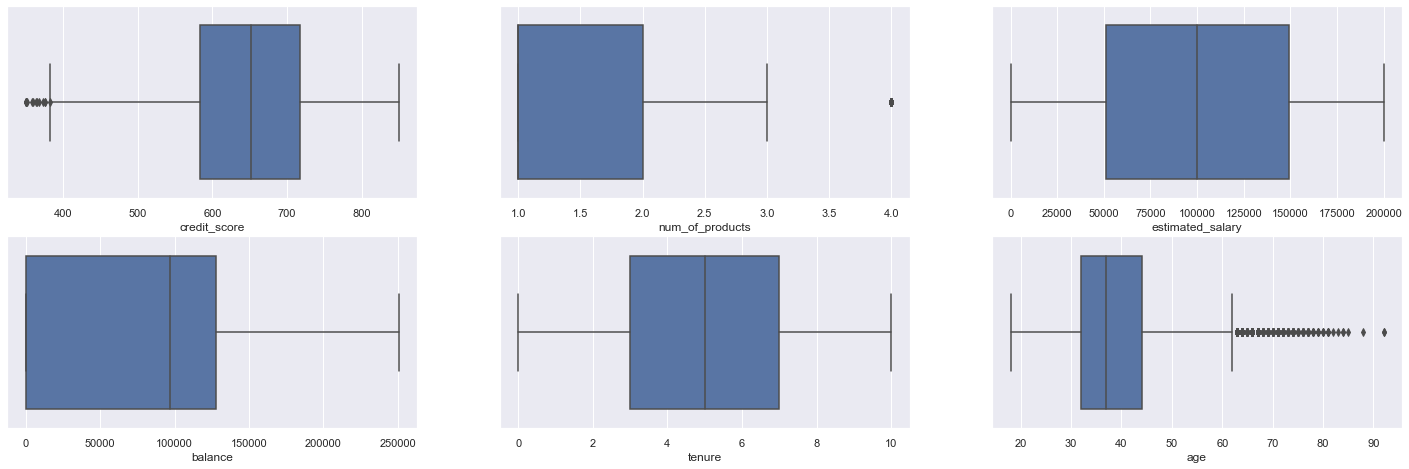

In [24]:
i = 1
for col in df1[num_cols]:
    plt.subplot(3, 3, i)
    ax = sns.boxplot(data = df1, x = col)
    i += 1

#### 1.6.3 Categorical Attributes

In [25]:
categorical_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])
categorical_attributes.columns

Index(['is_active_member', 'exited', 'has_cr_card', 'gender', 'geography'], dtype='object')

In [26]:
categorical_metrics(categorical_attributes, 'is_active_member')

,absolute,percent %
yes,5151,51.510
no,4849,48.490


In [27]:
categorical_metrics(categorical_attributes, 'has_cr_card')

,absolute,percent %
yes,7055,70.550
no,2945,29.450


In [28]:
categorical_metrics(categorical_attributes, 'exited')

,absolute,percent %
no,7963,79.630
yes,2037,20.370


In [29]:
categorical_metrics(categorical_attributes, 'gender')

,absolute,percent %
Male,5457,54.570
Female,4543,45.430


In [30]:
categorical_metrics(categorical_attributes, 'geography')

,absolute,percent %
France,5014,50.140
Germany,2509,25.090
Spain,2477,24.770


Important informations:
- There are outliers in **credit_score, num_of_products and age**
- The **churn ratio is 20.37%**;
- **70.6%** of the members **has credit card**;
- More than **50% of the clients** are **from France**

### 1.7 Save State

In [31]:
pickle.dump(df1, open(homepath + 'data/processed/df1.pkl', 'wb'))

## 2. FEATURE ENGINEERING

- **Tasks**
    - Dataset Checkpoint
    - Features Creatrion
    - Save State

### 2.1 Dataset Checkpoint

In [32]:
df2 = pickle.load(open(homepath + 'data/processed/df1.pkl', 'rb'))

### 2.2 Features Creation

In [33]:
df2.columns

Index(['is_active_member', 'exited', 'has_cr_card', 'credit_score',
       'num_of_products', 'estimated_salary', 'balance', 'tenure', 'age',
       'gender', 'geography'],
      dtype='object')

1. Creating `credit_score_per_salary`:

In [34]:
cs_salary = df2.loc[:, ['estimated_salary', 'credit_score']].groupby('estimated_salary').mean().reset_index()
cs_salary.columns = ['estimated_salary', 'credit_score_per_salary']

# merge
df2 = pd.merge(df2, cs_salary, on = 'estimated_salary', how = 'left')

2. Creating `credit_score_per_gender`:

In [36]:
cs_gender = df2.loc[:, ['gender', 'credit_score']].groupby('gender').mean().reset_index()
cs_gender.columns = ['gender', 'credit_score_per_gender']

# merge
df2 = pd.merge(df2, cs_gender, on = 'gender', how = 'left')

3. Creating `estimated_salary_per_country`:

In [37]:
estimated_salary_country = df2.loc[:, ['geography', 'estimated_salary']].groupby('geography').mean().reset_index()
estimated_salary_country.columns = ['geography', '_estimated_salary_per_country']

# merge
df2 = pd.merge(df2, estimated_salary_country, on = 'geography', how = 'left')

4. Creating `balance_per_age`:

In [38]:
balance_age = df2.loc[:, ['age', 'balance']].groupby('age').mean().reset_index()
balance_age.columns = ['age', 'balance_per_age']

# merge
df2 = pd.merge(df2, balance_age, on = 'age', how = 'left')

5. Creating `balance_per_num_of_products`:

In [39]:
balance_number_of_products = df2.loc[:, ['num_of_products', 'balance']].groupby('num_of_products').mean().reset_index()
balance_number_of_products.columns = ['num_of_products', 'balance_per_num_of_products']

# merge
df2 = pd.merge(df2, balance_number_of_products, on = 'num_of_products', how = 'left')

6. Creating LTV:

In [40]:
balance_tenure = df2.loc[:, ['tenure', 'balance']].groupby('tenure').mean().reset_index()
balance_tenure.columns = ['tenure', 'LTV']

# merge
df2 = pd.merge(df2, balance_tenure, on = 'tenure', how = 'left')

7. Creating tenure_per_country:

In [41]:
tenure_country = df2.loc[:, ['geography', 'tenure']].groupby('geography').mean().reset_index()
tenure_country.columns = ['geography', 'tenure_per_country']

# merge
df2 = pd.merge(df2, tenure_country, on = 'geography', how = 'left')

8. Creating num_of_products_per_age:

In [42]:
num_of_products_age = df2.loc[:, ['age', 'num_of_products']].groupby('age').mean().reset_index()
num_of_products_age.columns = ['age', 'num_of_products_per_age']

# merge
df2 = pd.merge(df2, num_of_products_age, on = 'age', how = 'left')

9. Credit life_stage

In [43]:
df2['life_stage'] = df2['age'].apply(lambda x: 'adolescence' if x <= 20 else 'adulthood' if (x > 20) & (x <= 35) else 'middle age' if (x > 35) & (x <= 60) else 'senior years')

In [44]:
verify_nan = pd.DataFrame({'Sum of NA': df2.isna().sum(), '% NA': df2.isna().sum()/df2.shape[0]})
verify_nan

,Sum of NA,% NA
is_active_member,0,0.000
exited,0,0.000
has_cr_card,0,0.000
credit_score,0,0.000
num_of_products,0,0.000
estimated_salary,0,0.000
balance,0,0.000
tenure,0,0.000
age,0,0.000
gender,0,0.000


### 2.3 Save State

In [45]:
pickle.dump(df2, open(homepath + 'data/processed/df2.pkl', 'wb'))

## 3. DATA FILTERING

- **Tasks**
    - Dataset Checkpoint
    - Filtering Rows
    - Save State

### 3.1 Dataset Checkpoint

In [46]:
df3 = pickle.load(open(homepath + 'data/processed/df2.pkl', 'rb'))

### 3.2 Filtering Rows

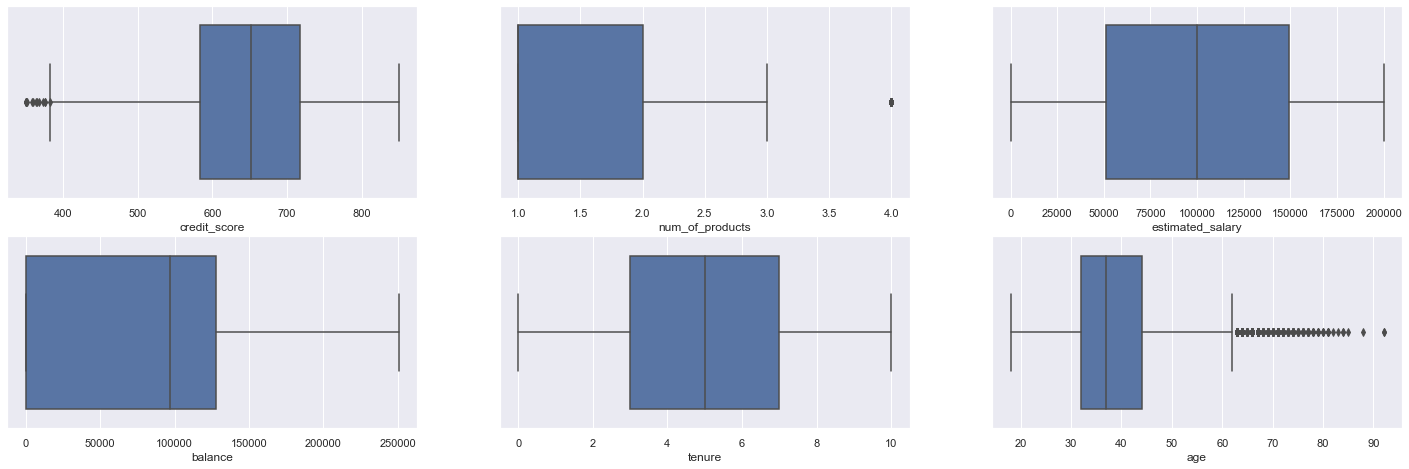

In [47]:
i = 1
for col in df3[num_cols]:
    plt.subplot(3, 3, i)
    ax = sns.boxplot(data = df3, x = col)
    i += 1

Age has outliers but these values ​​are considered important for the next analysis and training of the model.

In [48]:
# Filtering credit_score
df3 = df3.loc[df3['credit_score'] > 390, :]

# Filtering num_of_products
df3 = df3.loc[df3['num_of_products'] < 4, :]

### 3.3 Save State

In [49]:
pickle.dump(df3, open(homepath + 'data/processed/df3.pkl', 'wb'))

## 4.0 EXPLORATORY DATA ANALYSIS

- **Tasks**
    - Univariate Analysis
    - Bivariate Analysis
    - Multivariate Analysis

### 4.1 Dataset Checkpoint

In [50]:
df4 = pickle.load(open(homepath + 'data/processed/df3.pkl', 'rb'))

### 4.2 Report

In [55]:
# Pandas Proffiling Report
ppr1 = ProfileReport(df4, 'Churn Prediction First Report.', explorative = True)
ppr1.to_file(output_file = homepath + 'reports/ppr1.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 539.11it/s]


Warnings:
- balance has 36.3% zeros
- tenure has 4.1% zeros

### 4.4 Bivariate Analysis

In [56]:
sns.pairplot(df4);

# saving figure
plt.savefig(homepath + 'reports/figures/pairplot.png')

### 4.5 Multivariate Analysis

### 4.6 Save State

In [ ]:
pickle.dump(df4, open(homepath + 'data/processed/df4.pkl', 'wb'))

## 5.0 DATA PREPARATION 

- **Tasks**
    - Dataset Checkpoint
    - Encoding
    - Rescaling
    - Split Data
    - Balancing Data
    - Feature Selection
    - Save State

### 5.1 Dataset Checkpoint

In [ ]:
df5 = pickle.load(open(homepath + 'data/processed/df4.pkl', 'rb'))
df5.drop(['avg_salary', 'avg_credit_score', 'avg_balance', 'avg_tenure'], axis = 1, inplace = True)

### 5.2 Encoding

A form to transform categorical variables into numerical

In [ ]:
# label encoding 
gender_encoding = {'Male': 0 , 'Female': 1}
df5['gender'] = df5['gender'].map(gender_encoding)

questions_encoding = {'yes': 1,'no': 0}
df5['is_active_member'] = df3['is_active_member'].map(questions_encoding)
df5['has_cr_card'] = df5['has_cr_card'].map(questions_encoding)
df5['exited'] = df5['exited'].map(questions_encoding)

# one hot encoding encoding 
df5 = pd.get_dummies(df5, prefix=['country'], columns=['geography'])
df5 = pd.get_dummies(df5, prefix=['gender'], columns=['gender'])

In [ ]:
df5.columns

Index(['is_active_member', 'exited', 'has_cr_card', 'credit_score',
       'num_of_products', 'estimated_salary', 'balance', 'tenure', 'age',
       'estimated_salary_per_credit_score', 'estimated_salary_per_gender',
       '_estimated_salary_per_country', 'balance_per_age',
       'balance_per_country', 'balance_per_num_of_products', 'LTV',
       'estimated_salary_credit_card', 'tenure_per_country',
       'tenure_per_num_of_products', 'num_of_products_per_age',
       'num_of_products_per_country', 'country_France', 'country_Germany',
       'country_Spain', 'gender_0', 'gender_1'],
      dtype='object')

### 5.3 Rescaling

[Reference](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)

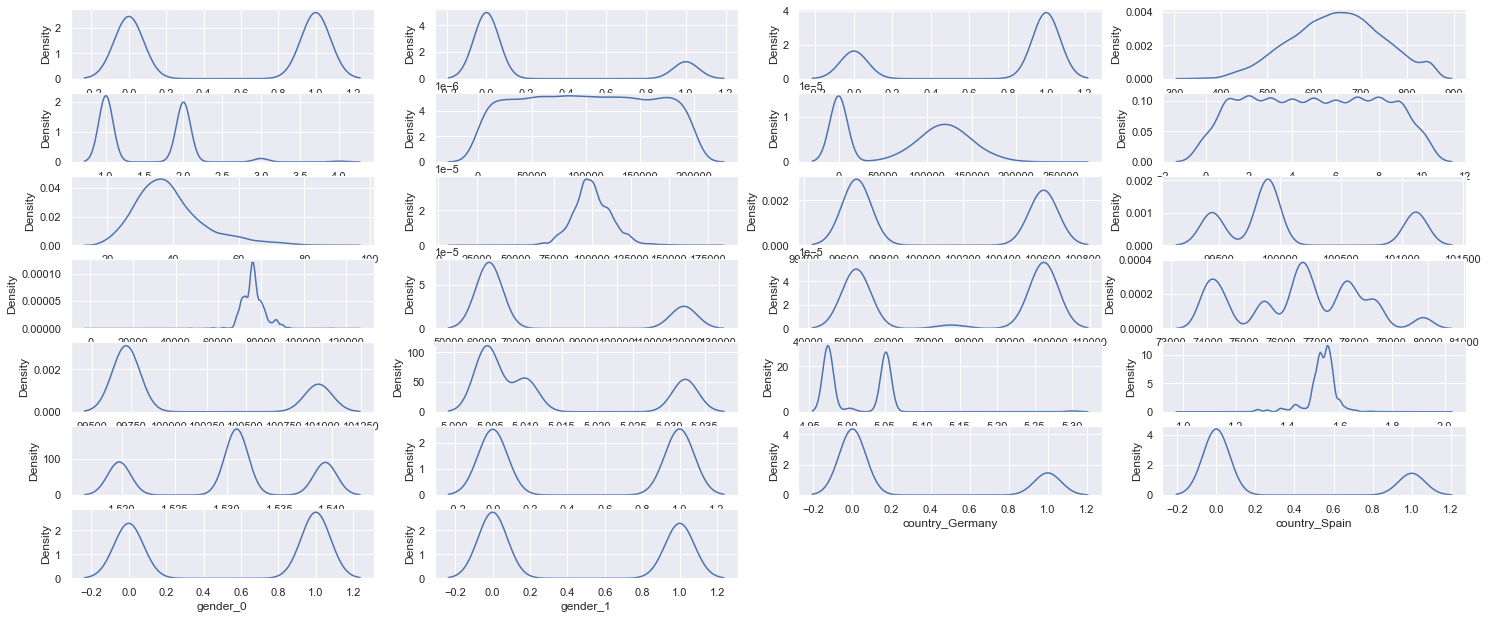

In [ ]:
i = 1
for col in df5.columns:
    plt.subplot(8, 4, i)
    sns.kdeplot(df5[col])
    i += 1

In [ ]:
df5.columns

Index(['is_active_member', 'exited', 'has_cr_card', 'credit_score',
       'num_of_products', 'estimated_salary', 'balance', 'tenure', 'age',
       'estimated_salary_per_credit_score', 'estimated_salary_per_gender',
       '_estimated_salary_per_country', 'balance_per_age',
       'balance_per_country', 'balance_per_num_of_products', 'LTV',
       'estimated_salary_credit_card', 'tenure_per_country',
       'tenure_per_num_of_products', 'num_of_products_per_age',
       'num_of_products_per_country', 'country_France', 'country_Germany',
       'country_Spain', 'gender_0', 'gender_1'],
      dtype='object')

In [ ]:
# Min-Max Scaler
mms = MinMaxScaler()

min_max_scaler = ['is_active_member', 'exited', 'has_cr_card', 'estimated_salary', 'balance', 'tenure',
'estimated_salary_per_gender', '_estimated_salary_per_country', 'balance_per_country', 'LTV', 'estimated_salary_credit_card',
'tenure_per_country', 'country_France', 'country_Germany', 'country_Spain', 'gender_0', 'gender_1']

for col in min_max_scaler:
    df5[col] = mms.fit_transform(df5[[col]].values)

# Robust Scaler
rs = RobustScaler()

robust_scaler = ['credit_score', 'num_of_products', 'age', 'estimated_salary_per_credit_score', 'balance_per_age',
'balance_per_num_of_products', 'tenure_per_num_of_products', 'num_of_products_per_age',
'num_of_products_per_country']

for col in robust_scaler:
    df5[col] = mms.fit_transform(df5[[col]].values)

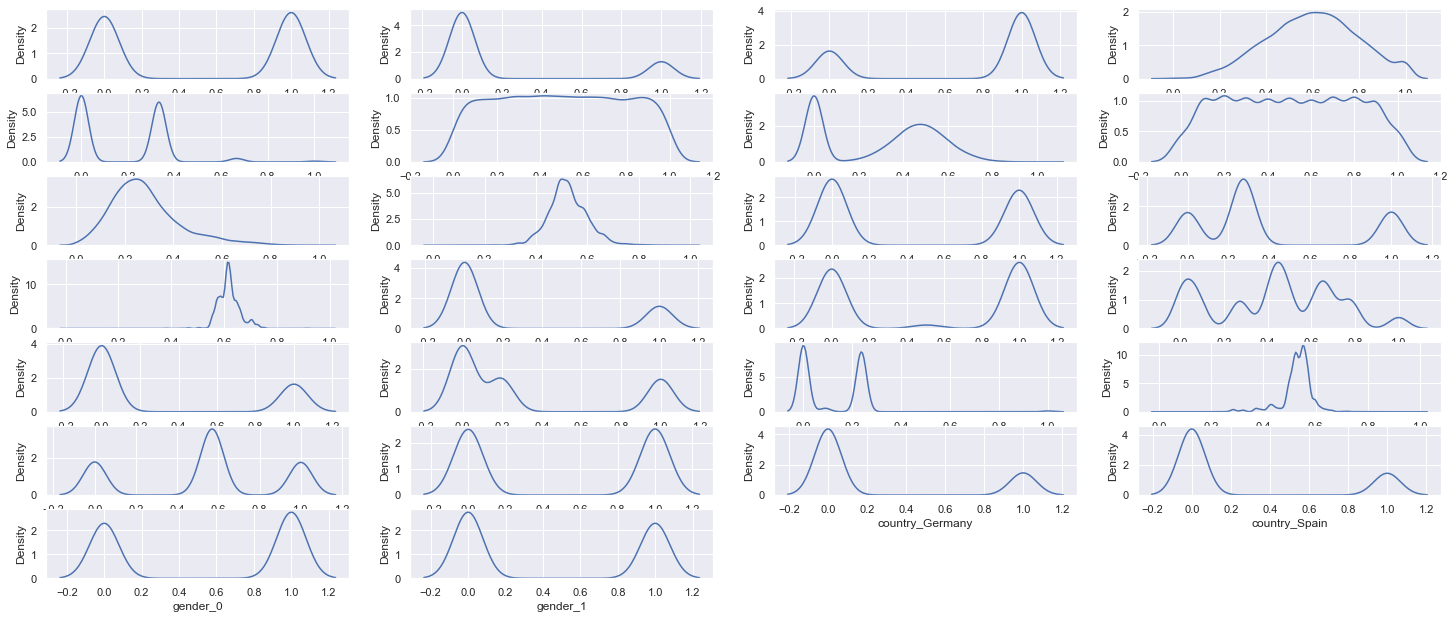

In [ ]:
i = 1
for col in df5.columns:
    plt.subplot(8, 4, i)
    sns.kdeplot(df5[col])
    i += 1

### 5.4 Split Data

The target is **exited**

In [ ]:
X = df5.drop(['exited'], axis = 1)
#target
y = df5['exited']

X_train_imbalanced, X_test, y_train_imbalanced, y_test = train_test_split(X , y, test_size = 0.33, shuffle = True, random_state = seed)

### 5.5 Balancing Data

In this dataset, **the proportion of churn clients is 20.4% and the the rest is not churn clients**. The target variable is imbalanced, a problem for Machine Learning Algorithms that demand **balanced data for a good performance**.

[Reference](https://towardsdatascience.com/applying-smote-for-class-imbalance-with-just-a-few-lines-of-code-python-cdf603e58688)

In [ ]:
balancer = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = 1)

X_train, y_train = balancer.fit_resample(X_train_imbalanced, y_train_imbalanced)

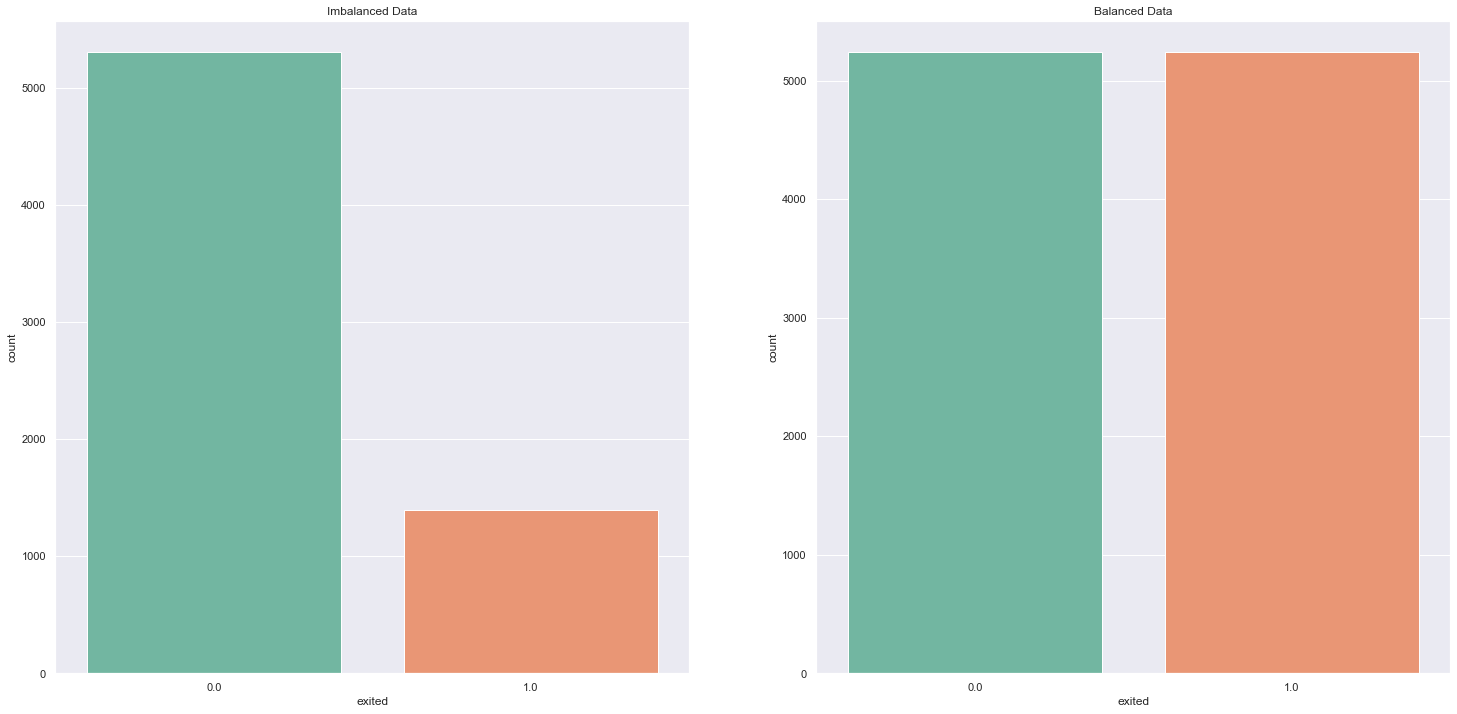

In [ ]:
# creating subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

ax = sns.countplot(x = y_train_imbalanced, ax = ax1, palette = 'Set2').set_title('Imbalanced Data')
ax = sns.countplot(x = y_train, ax = ax2, palette = 'Set2').set_title('Balanced Data')

### 5.6 Feature Selection

In [ ]:
rf = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = seed)

boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = seed).fit(X_train.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	12
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	12
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	12
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	12
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	13


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	13


In [ ]:
cols_selected = boruta.support_.tolist()

cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

cols_not_selected_boruta = list( np.setdiff1d(X_train.columns, cols_selected_boruta))

In [ ]:
cols_selected_boruta

['credit_score',
 'num_of_products',
 'estimated_salary',
 'balance',
 'tenure',
 'age',
 'estimated_salary_per_credit_score',
 'balance_per_age',
 'balance_per_num_of_products',
 'LTV',
 'tenure_per_num_of_products',
 'num_of_products_per_age']

In [ ]:
cols_not_selected_boruta

['_estimated_salary_per_country',
 'balance_per_country',
 'country_France',
 'country_Germany',
 'country_Spain',
 'estimated_salary_credit_card',
 'estimated_salary_per_gender',
 'gender_0',
 'gender_1',
 'has_cr_card',
 'is_active_member',
 'num_of_products_per_country',
 'tenure_per_country']

In [ ]:
X_train.columns

Index(['is_active_member', 'has_cr_card', 'credit_score', 'num_of_products',
       'estimated_salary', 'balance', 'tenure', 'age',
       'estimated_salary_per_credit_score', 'estimated_salary_per_gender',
       '_estimated_salary_per_country', 'balance_per_age',
       'balance_per_country', 'balance_per_num_of_products', 'LTV',
       'estimated_salary_credit_card', 'tenure_per_country',
       'tenure_per_num_of_products', 'num_of_products_per_age',
       'num_of_products_per_country', 'country_France', 'country_Germany',
       'country_Spain', 'gender_0', 'gender_1'],
      dtype='object')

In [ ]:
cols_drop = ['_estimated_salary_per_country', 'balance_per_country', 'country_France', 'country_Germany', 'country_Spain', 'estimated_salary_credit_card', 'estimated_salary_per_gender',
'gender_0', 'gender_1', 'has_cr_card', 'is_active_member', 'num_of_products_per_country',
'tenure_per_country']

In [ ]:
X_train.drop(cols_drop, axis=1, inplace=True)
X_test.drop(cols_drop, axis=1, inplace=True)

## 6.0 MACHINE LEARNING MODELLING 

- **Tasks**
    - 

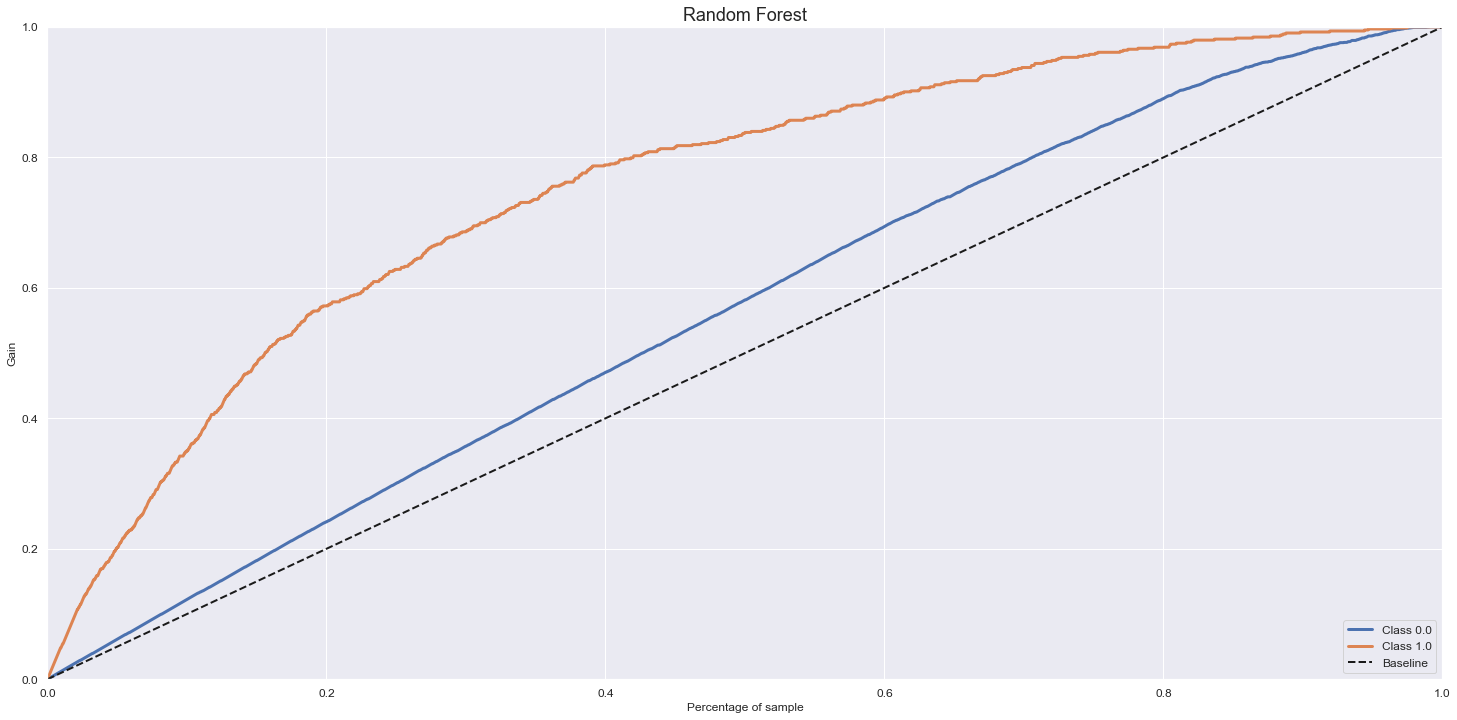

In [ ]:
#model definition
rf = RandomForestClassifier(n_estimators = 300, random_state = seed)

#model training
rf.fit(X_train, y_train)

#model prediction
yhat_rf = rf.predict_proba(X_test)

# Accumulative gain
skplt.metrics.plot_cumulative_gain(y_test, yhat_rf);
plt.title( 'Random Forest', fontsize = 18);

## 7.0 HYPERPARAMETER FINE TUNING

- **Tasks**
    - Dataset Checkpoint

## 8.0 MODEL TRAINING